In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.metrics import classification_report

In [2]:
email_data=pd.read_pickle("email_campaigns.pkl")

In [3]:
email_data[:]

[{'example1': [{'subject': '🚀 Propel Your Marketing ROI with Advanced Analytics!',
    'body': "Hey [Recipient's Name],\n\nReady to see your marketing performance soar? With our cutting-edge Marketing Analytics services, your business can harness the power of data to drive decision-making and skyrocket ROI!\n\nQuick question - are you leveraging your data to its full potential? Let's talk strategy! 👉 [meeting link]\n\nBest,\n[Your Name]",
    'opened': False,
    'meeting link clicked': False,
    'responded': False},
   {'subject': 'Data is Your Superpower Unlock Insights with Us',
    'body': "Hi [Recipient's Name],\n\nI'm reaching out again because I believe our last message might've slipped through the cracks. With your goals in mind, our marketing analytics can translate your data into actionable strategies that can redefine your marketing's success.\n\nCan we help you harness this superpower? Book a time on my calendar: [meeting link]. Looking forward to connecting!\n\nCheers,\n[

In [4]:
# Corrected transformation process without trying to modify the 'campaign' key
email_campaigns = []
for item in email_data:
    for campaign_name, emails in item.items():
        for email in emails:
            if isinstance(email, dict):
                email['campaign'] = campaign_name  # Adding the campaign name to each email dictionary
                email_campaigns.append(email)

# Creating DataFrame
df_email_campaigns = pd.DataFrame(email_campaigns)

# Displaying the first few rows of the DataFrame
df_email_campaigns.head()

,subject,body,opened,meeting link clicked,responded,campaign,meeting_link_clicked
0,🚀 Propel Your Marketing ROI with Advanced Anal...,"Hey [Recipient's Name],\n\nReady to see your m...",False,False,False,example1,NaN
1,Data is Your Superpower 📊 Unlock Insights with Us,"Hi [Recipient's Name],\n\nI'm reaching out aga...",True,False,False,example1,NaN
2,Turn Marketing Data Into Decisions 🧐 Let's Exp...,"Greetings [Recipient's Name],\n\nWe haven't co...",False,False,False,example1,NaN
3,Marketing Success is a Click Away - Let's Chat...,"Hello [Recipient's Name],\n\nIt's clear that y...",True,True,False,example1,NaN
4,🚀 Boost Your Brand's Visibility with Proven Ma...,"Hi [Recipient's Name],\n\nIn the digital age, ...",False,False,False,example1,NaN


In [5]:
df_email_campaigns.shape

(154, 7)

In [6]:
df_email_campaigns.columns

Index(['subject', 'body', 'opened', 'meeting link clicked', 'responded',
       'campaign', 'meeting_link_clicked'],
      dtype='object')

In [7]:
df_email_campaigns.isnull().sum()

subject                   0
body                      0
opened                    0
meeting link clicked     16
responded                 0
campaign                  0
meeting_link_clicked    138
dtype: int64

In [8]:
df_email_campaigns['clicked_meeting_link'] = df_email_campaigns['meeting link clicked'] | df_email_campaigns['meeting_link_clicked']

In [9]:
df_email_campaigns.head()

,subject,body,opened,meeting link clicked,responded,campaign,meeting_link_clicked,clicked_meeting_link
0,🚀 Propel Your Marketing ROI with Advanced Anal...,"Hey [Recipient's Name],\n\nReady to see your m...",False,False,False,example1,NaN,False
1,Data is Your Superpower 📊 Unlock Insights with Us,"Hi [Recipient's Name],\n\nI'm reaching out aga...",True,False,False,example1,NaN,False
2,Turn Marketing Data Into Decisions 🧐 Let's Exp...,"Greetings [Recipient's Name],\n\nWe haven't co...",False,False,False,example1,NaN,False
3,Marketing Success is a Click Away - Let's Chat...,"Hello [Recipient's Name],\n\nIt's clear that y...",True,True,False,example1,NaN,True
4,🚀 Boost Your Brand's Visibility with Proven Ma...,"Hi [Recipient's Name],\n\nIn the digital age, ...",False,False,False,example1,NaN,False


In [10]:
df_email_campaigns=df_email_campaigns.drop(columns=["meeting link clicked","meeting_link_clicked"])

In [11]:
df_email_campaigns.head()

,subject,body,opened,responded,campaign,clicked_meeting_link
0,🚀 Propel Your Marketing ROI with Advanced Anal...,"Hey [Recipient's Name],\n\nReady to see your m...",False,False,example1,False
1,Data is Your Superpower 📊 Unlock Insights with Us,"Hi [Recipient's Name],\n\nI'm reaching out aga...",True,False,example1,False
2,Turn Marketing Data Into Decisions 🧐 Let's Exp...,"Greetings [Recipient's Name],\n\nWe haven't co...",False,False,example1,False
3,Marketing Success is a Click Away - Let's Chat...,"Hello [Recipient's Name],\n\nIt's clear that y...",True,False,example1,True
4,🚀 Boost Your Brand's Visibility with Proven Ma...,"Hi [Recipient's Name],\n\nIn the digital age, ...",False,False,example1,False


In [12]:
df_email_campaigns.isnull().sum()

subject                 0
body                    0
opened                  0
responded               0
campaign                0
clicked_meeting_link    0
dtype: int64

In [13]:
df_email_campaigns["campaign"].value_counts()

example1                            81
series1                             10
marketingAnalyticsSeries             8
HRConsultingSeries                   7
HR_Consulting_Series                 7
series_marketing_analytics           6
financial_advisory_series            5
series_IT_Solutions                  4
Series1_HR_Consulting                4
email_series_marketing_analytics     4
marketingAnalytics0                  3
MarketingAnalyticsSeries             3
Series_IT_Solutions                  3
legal_services0                      3
IT_Solutions_Series                  2
Marketing_Analytics_Series           2
series_legal                         2
Name: campaign, dtype: int64

In [14]:
# Defining a mapping for campaign categories
campaign_mapping = {
    'example1': 'Marketing_Analytics',
    'marketingAnalyticsSeries': 'Marketing_Analytics',
    'MarketingAnalyticsSeries': 'Marketing_Analytics',
    'email_series_marketing_analytics': 'Marketing_Analytics',
    'marketingAnalytics0': 'Marketing_Analytics',
    'Marketing_Analytics_Series': 'Marketing_Analytics',
    'series_marketing_analytics': 'Marketing_Analytics',
    'HRConsultingSeries': 'HR_Consulting',
    'HR_Consulting_Series': 'HR_Consulting',
    'Series1_HR_Consulting': 'HR_Consulting',
    'IT_Solutions_Series': 'IT_Solutions',
    'Series_IT_Solutions': 'IT_Solutions',
    'series_IT_Solutions': 'IT_Solutions',
    'legal_services0': 'Legal_Services',
    'series_legal': 'Legal_Services',
    'financial_advisory_series': 'Financial_Advisory',
    'series1': 'General_Series',
    'Series1': 'General_Series'
}

# Applying the mapping to the campaign column
df_email_campaigns['campaign'] = df_email_campaigns['campaign'].replace(campaign_mapping)

# Displaying the unique values in the campaign column after replacement
df_email_campaigns['campaign'].unique()


array(['Marketing_Analytics', 'HR_Consulting', 'Legal_Services',
       'IT_Solutions', 'General_Series', 'Financial_Advisory'],
      dtype=object)

In [15]:
df_email_campaigns.head()

,subject,body,opened,responded,campaign,clicked_meeting_link
0,🚀 Propel Your Marketing ROI with Advanced Anal...,"Hey [Recipient's Name],\n\nReady to see your m...",False,False,Marketing_Analytics,False
1,Data is Your Superpower 📊 Unlock Insights with Us,"Hi [Recipient's Name],\n\nI'm reaching out aga...",True,False,Marketing_Analytics,False
2,Turn Marketing Data Into Decisions 🧐 Let's Exp...,"Greetings [Recipient's Name],\n\nWe haven't co...",False,False,Marketing_Analytics,False
3,Marketing Success is a Click Away - Let's Chat...,"Hello [Recipient's Name],\n\nIt's clear that y...",True,False,Marketing_Analytics,True
4,🚀 Boost Your Brand's Visibility with Proven Ma...,"Hi [Recipient's Name],\n\nIn the digital age, ...",False,False,Marketing_Analytics,False


[False True]
[False  True]
[False True]
   opened_numeric  clicked_meeting_link_numeric  responded_numeric
0               0                             0                  0
1               1                             0                  0
2               0                             0                  0
3               1                             1                  0
4               0                             0                  0


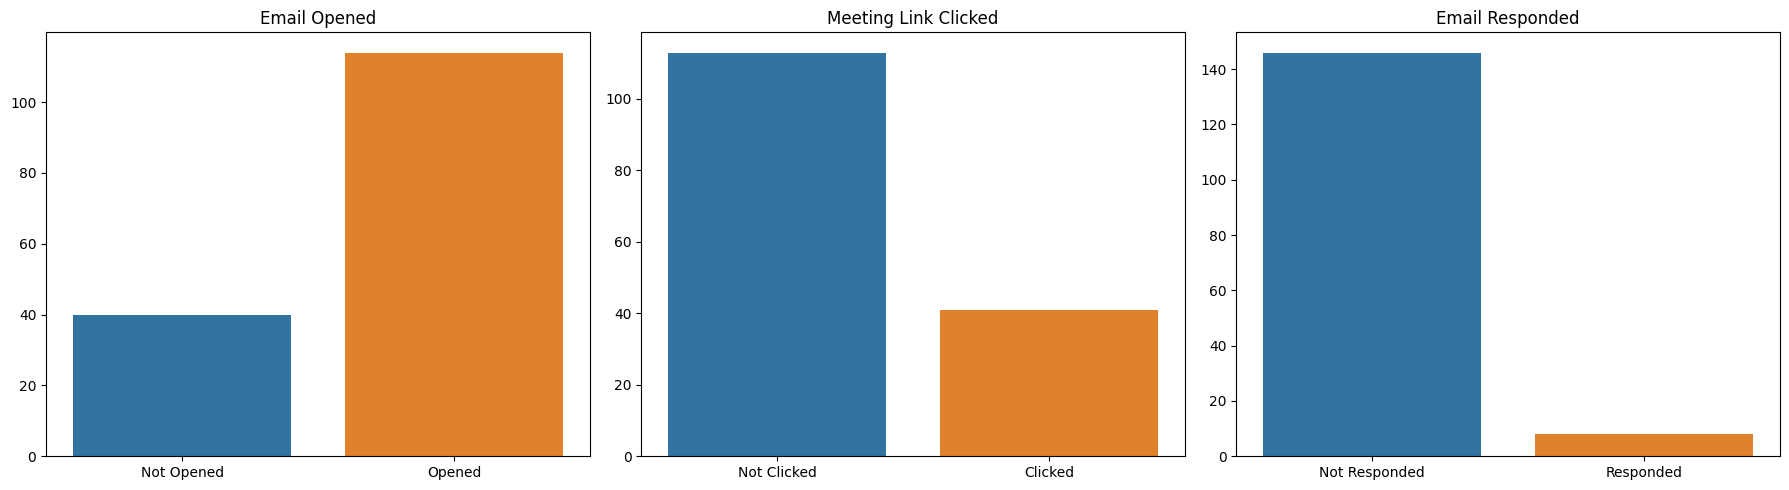

In [16]:
# Check unique values in the columns to ensure correct mapping
print(df_email_campaigns['opened'].unique())
print(df_email_campaigns['clicked_meeting_link'].unique())
print(df_email_campaigns['responded'].unique())

# Converting binary variables to numeric for analysis
df_email_campaigns['opened_numeric'] = df_email_campaigns['opened'].map({True: 1, False: 0})
df_email_campaigns['clicked_meeting_link_numeric'] = df_email_campaigns['clicked_meeting_link'].map({True: 1, False: 0})
df_email_campaigns['responded_numeric'] = df_email_campaigns['responded'].map({True: 1, False: 0})

# Checking if the mapping is done correctly
print(df_email_campaigns[['opened_numeric', 'clicked_meeting_link_numeric', 'responded_numeric']].head())

# Distribution of 'Opened'
opened_dist = df_email_campaigns['opened_numeric'].value_counts()

# Distribution of 'Meeting Link Clicked'
meeting_link_clicked_dist = df_email_campaigns['clicked_meeting_link_numeric'].value_counts()

# Distribution of 'Responded'
responded_dist = df_email_campaigns['responded_numeric'].value_counts()

# Plotting distributions
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(x=opened_dist.index, y=opened_dist.values, ax=ax[0])
ax[0].set_title('Email Opened')
ax[0].set_xticklabels(['Not Opened', 'Opened'])

sns.barplot(x=meeting_link_clicked_dist.index, y=meeting_link_clicked_dist.values, ax=ax[1])
ax[1].set_title('Meeting Link Clicked')
ax[1].set_xticklabels(['Not Clicked', 'Clicked'])

sns.barplot(x=responded_dist.index, y=responded_dist.values, ax=ax[2])
ax[2].set_title('Email Responded')
ax[2].set_xticklabels(['Not Responded', 'Responded'])

plt.tight_layout()
plt.show()


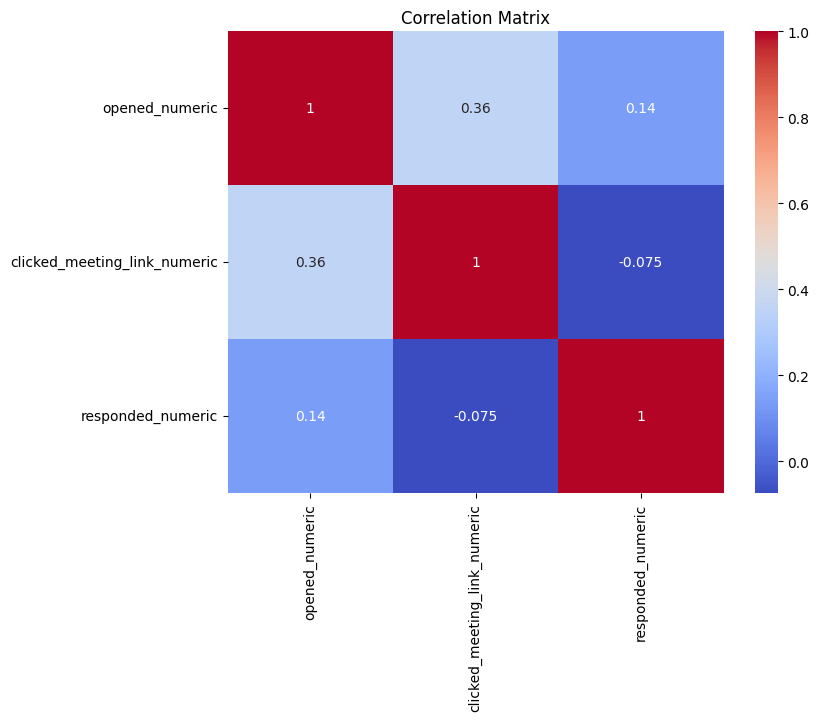

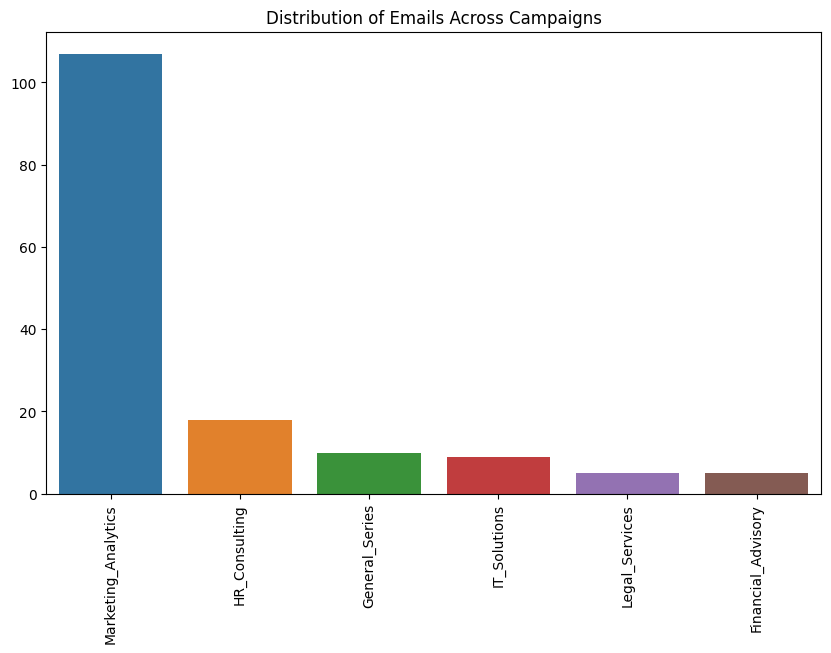

(                              opened_numeric  clicked_meeting_link_numeric  \
 opened_numeric                      1.000000                      0.356804   
 clicked_meeting_link_numeric        0.356804                      1.000000   
 responded_numeric                   0.138658                     -0.074799   
 
                               responded_numeric  
 opened_numeric                         0.138658  
 clicked_meeting_link_numeric          -0.074799  
 responded_numeric                      1.000000  ,
 Marketing_Analytics    107
 HR_Consulting           18
 General_Series          10
 IT_Solutions             9
 Legal_Services           5
 Financial_Advisory       5
 Name: campaign, dtype: int64)

In [17]:
# Bivariate Analysis: Exploring relationships between 'Opened', 'Meeting Link Clicked', and 'Responded'

# Correlation matrix for the binary variables
correlation_matrix = df_email_campaigns[['opened_numeric', 'clicked_meeting_link_numeric', 'responded_numeric']].corr()

# Campaign analysis: Distribution of emails across different campaigns
campaign_dist = df_email_campaigns['campaign'].value_counts()

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Plotting the campaign distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=campaign_dist.index, y=campaign_dist.values)
plt.title('Distribution of Emails Across Campaigns')
plt.xticks(rotation=90)
plt.show()

correlation_matrix, campaign_dist

In [18]:
# Analyzing engagement rates by campaign
# Calculating open, click-through, and response rates for each campaign

# Grouping by campaign
grouped_by_campaign = df_email_campaigns.groupby('campaign').agg(
    total_emails=pd.NamedAgg(column='subject', aggfunc='count'),
    opened_emails=pd.NamedAgg(column='opened_numeric', aggfunc='sum'),
    clicked_emails=pd.NamedAgg(column='clicked_meeting_link_numeric', aggfunc='sum'),
    responded_emails=pd.NamedAgg(column='responded_numeric', aggfunc='sum')
)

# Calculating rates
grouped_by_campaign['open_rate'] = grouped_by_campaign['opened_emails'] / grouped_by_campaign['total_emails']
grouped_by_campaign['click_through_rate'] = grouped_by_campaign['clicked_emails'] / grouped_by_campaign['total_emails']
grouped_by_campaign['response_rate'] = grouped_by_campaign['responded_emails'] / grouped_by_campaign['total_emails']

grouped_by_campaign.sort_values(by='total_emails', ascending=False, inplace=True)
grouped_by_campaign

,total_emails,opened_emails,clicked_emails,responded_emails,open_rate,click_through_rate,response_rate
campaign,,,,,,,
Marketing_Analytics,107,79,28,5,0.738318,0.261682,0.046729
HR_Consulting,18,12,4,0,0.666667,0.222222,0.000000
General_Series,10,7,3,1,0.700000,0.300000,0.100000
IT_Solutions,9,8,3,2,0.888889,0.333333,0.222222
Financial_Advisory,5,4,1,0,0.800000,0.200000,0.000000
Legal_Services,5,4,2,0,0.800000,0.400000,0.000000


In [19]:
df_email_campaigns.head()

,subject,body,opened,responded,campaign,clicked_meeting_link,opened_numeric,clicked_meeting_link_numeric,responded_numeric
0,🚀 Propel Your Marketing ROI with Advanced Anal...,"Hey [Recipient's Name],\n\nReady to see your m...",False,False,Marketing_Analytics,False,0,0,0
1,Data is Your Superpower 📊 Unlock Insights with Us,"Hi [Recipient's Name],\n\nI'm reaching out aga...",True,False,Marketing_Analytics,False,1,0,0
2,Turn Marketing Data Into Decisions 🧐 Let's Exp...,"Greetings [Recipient's Name],\n\nWe haven't co...",False,False,Marketing_Analytics,False,0,0,0
3,Marketing Success is a Click Away - Let's Chat...,"Hello [Recipient's Name],\n\nIt's clear that y...",True,False,Marketing_Analytics,True,1,1,0
4,🚀 Boost Your Brand's Visibility with Proven Ma...,"Hi [Recipient's Name],\n\nIn the digital age, ...",False,False,Marketing_Analytics,False,0,0,0


In [20]:
from sklearn.preprocessing import LabelEncoder
# Preprocessing
# Encoding the 'campaign' column
le = LabelEncoder()
df_email_campaigns['campaign_numeric'] = le.fit_transform(df_email_campaigns['campaign'])

In [21]:
df_email_campaigns.head()

,subject,body,opened,responded,campaign,clicked_meeting_link,opened_numeric,clicked_meeting_link_numeric,responded_numeric,campaign_numeric
0,🚀 Propel Your Marketing ROI with Advanced Anal...,"Hey [Recipient's Name],\n\nReady to see your m...",False,False,Marketing_Analytics,False,0,0,0,5
1,Data is Your Superpower 📊 Unlock Insights with Us,"Hi [Recipient's Name],\n\nI'm reaching out aga...",True,False,Marketing_Analytics,False,1,0,0,5
2,Turn Marketing Data Into Decisions 🧐 Let's Exp...,"Greetings [Recipient's Name],\n\nWe haven't co...",False,False,Marketing_Analytics,False,0,0,0,5
3,Marketing Success is a Click Away - Let's Chat...,"Hello [Recipient's Name],\n\nIt's clear that y...",True,False,Marketing_Analytics,True,1,1,0,5
4,🚀 Boost Your Brand's Visibility with Proven Ma...,"Hi [Recipient's Name],\n\nIn the digital age, ...",False,False,Marketing_Analytics,False,0,0,0,5


In [22]:
df_email_campaigns['text'] = df_email_campaigns['subject'] + " " + df_email_campaigns['body']

In [23]:
df_email_campaigns=df_email_campaigns.drop(columns=["subject","body","opened","responded","campaign","clicked_meeting_link"])

In [24]:
df_email_campaigns.head()

,opened_numeric,clicked_meeting_link_numeric,responded_numeric,campaign_numeric,text
0,0,0,0,5,🚀 Propel Your Marketing ROI with Advanced Anal...
1,1,0,0,5,Data is Your Superpower 📊 Unlock Insights with...
2,0,0,0,5,Turn Marketing Data Into Decisions 🧐 Let's Exp...
3,1,1,0,5,Marketing Success is a Click Away - Let's Chat...
4,0,0,0,5,🚀 Boost Your Brand's Visibility with Proven Ma...


In [25]:
df_email_campaigns.to_csv("df_email_campaigns.csv",index=False)

In [26]:
df_email_campaigns["clicked_meeting_link_numeric"].value_counts()

0    113
1     41
Name: clicked_meeting_link_numeric, dtype: int64

In [27]:
df_email_campaigns["opened_numeric"].value_counts()

1    114
0     40
Name: opened_numeric, dtype: int64

In [28]:
# Defining the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Function to encode text data using BERT
def encode_text(texts, tokenizer, max_length=512):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    return input_ids, attention_masks

# Preprocessing the text data
input_ids, attention_masks = encode_text(df_email_campaigns['text'], tokenizer)

# Extracting features from BERT
with torch.no_grad():
    last_hidden_states = bert_model(input_ids, attention_mask=attention_masks)

# Using the mean of the last hidden state as features
features = last_hidden_states[0][:, 0, :].numpy()

# Standardizing the non-text features and concatenate with BERT features
scaler = StandardScaler()
non_text_features = df_email_campaigns.drop(columns=['text', 'opened_numeric']).values
non_text_features_scaled = scaler.fit_transform(non_text_features)

# Combining BERT features with other features
combined_features = np.concatenate((features, non_text_features_scaled), axis=1)

# Preparing target variable and split the dataset into train, validation, and test sets
y = df_email_campaigns['opened_numeric'].values
X_train, X_temp, y_train, y_temp = train_test_split(combined_features, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Applying SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Defining a simple neural network for classification
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Initializing the model
model = SimpleNN(input_size=X_train_smote.shape[1])

# Defining the loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Converting the data to torch tensors
X_train_tensor = torch.tensor(X_train_smote, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_smote, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Createing data loaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)

In [32]:
num_epochs = 10
for epoch in range(num_epochs):
    # Training
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        outputs = model(X_val_tensor).squeeze()
        val_predictions = (outputs > 0.5).float()
        val_loss = criterion(outputs, y_val_tensor)
        print(f"Epoch {epoch+1}, Validation Loss: {val_loss.item():.4f}")

Epoch 1, Validation Loss: 0.6071
Epoch 2, Validation Loss: 0.6833
Epoch 3, Validation Loss: 0.5947
Epoch 4, Validation Loss: 0.6196
Epoch 5, Validation Loss: 0.6577
Epoch 6, Validation Loss: 0.5630
Epoch 7, Validation Loss: 0.7067
Epoch 8, Validation Loss: 0.5890
Epoch 9, Validation Loss: 0.6198
Epoch 10, Validation Loss: 0.6314


In [33]:
# Evaluating the model on the test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor).squeeze()
    predictions = (outputs > 0.5).float()
    print(classification_report(y_test_tensor, predictions))

              precision    recall  f1-score   support

         0.0       0.60      0.75      0.67         4
         1.0       0.95      0.90      0.92        20

    accuracy                           0.88        24
   macro avg       0.77      0.82      0.79        24
weighted avg       0.89      0.88      0.88        24

